# Main Quest
# Chest X-Ray image classification

## 1. 데이터 다운로드

In [19]:
pip install kaggle

UnboundLocalError: local variable 'child' referenced before assignment

In [ ]:
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99%|██████████████████████████████████████▋| 2.28G/2.29G [00:07<00:00, 308MB/s]
100%|███████████████████████████████████████| 2.29G/2.29G [00:07<00:00, 323MB/s]


In [10]:
!unzip -qq chest-xray-pneumonia.zip

## 2. 데이터 전처리

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    'chest_xray/train/',
    image_size=(150, 150),
    batch_size=32
)
train_dataset = train_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

val_dataset = image_dataset_from_directory(
    'chest_xray/val/',
    image_size=(150, 150),
    batch_size=32
)
val_dataset = val_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

test_dataset = image_dataset_from_directory(
    'chest_xray/test/',
    image_size=(150, 150),
    batch_size=32
)
test_dataset = test_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


- 이미지 크기가 너무 크기 때문에 150 * 150 사이즈로 변경하였습니다.
- x-ray 이미지이기 때문에 컬러 이미지(3채널)에서 흑백 이미지(1채널)로 변경하였습니다.

#### Data augmentation

- 수평 반전(좌우 반전)
- -36~+36도 회전
- -10~+10% 축소/확대

In [2]:
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

## 3. 모델 설계

모델은 VGG16을 사용하겠습니다.

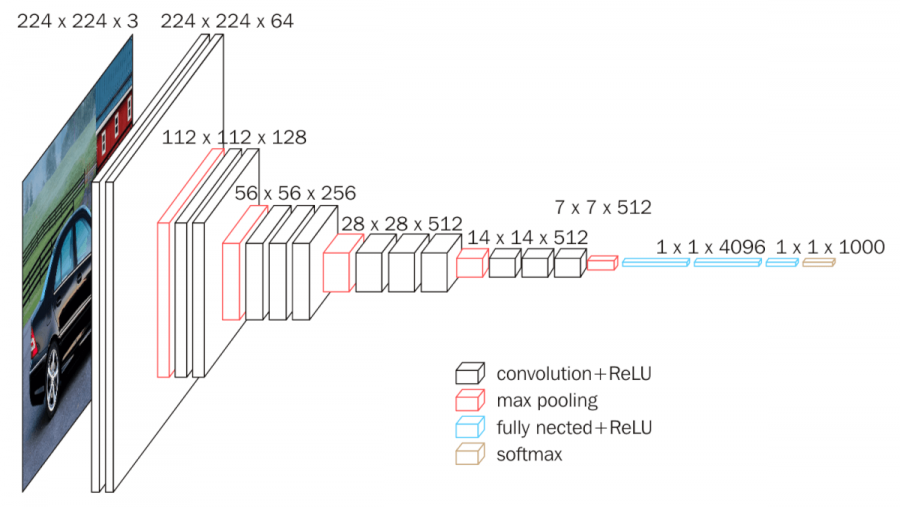

In [12]:
inputs = keras.Input((150, 150, 1))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(8, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(8, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 1)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 150, 150, 8)       80        
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 150, 150, 8)       584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 75, 75, 16)        1168

## 4. 모델 학습

In [13]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="chest_with_vgg16.keras",
        save_best_only=True,
        monitor='val_loss'
    ),
    keras.callbacks.TensorBoard(
        log_dir="vgg16/logs"
    )
]

In [14]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history = model.fit(train_dataset, validation_data=val_dataset,
                    epochs=50, callbacks=callbacks)

Epoch 1/50
163/163 [==============================] - 19s 100ms/step - loss: 0.6292 - accuracy: 0.7395 - val_loss: 0.7547 - val_accuracy: 0.5000
Epoch 2/50
163/163 [==============================] - 17s 100ms/step - loss: 0.5754 - accuracy: 0.7429 - val_loss: 0.8872 - val_accuracy: 0.5000
Epoch 3/50
163/163 [==============================] - 17s 99ms/step - loss: 0.5485 - accuracy: 0.7297 - val_loss: 1.3576 - val_accuracy: 0.5000
Epoch 4/50
163/163 [==============================] - 17s 98ms/step - loss: 0.4576 - accuracy: 0.8163 - val_loss: 1.3372 - val_accuracy: 0.5625


In [15]:
model.evaluate(test_dataset)

20/20 [==============================] - 1s 42ms/step - loss: 0.6622 - accuracy: 0.7131


[0.6622467041015625, 0.7131410241127014]

https://tensorboard.dev/experiment/5bY1dSzNT9ONUzasG5Wqug/#scalars
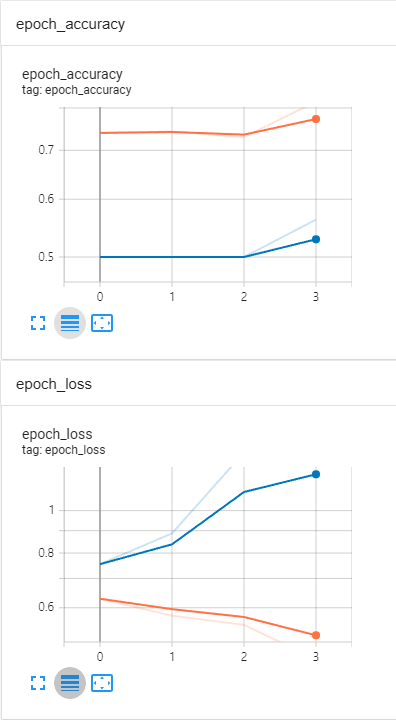

# 모델 변경

## 5. ResNet34

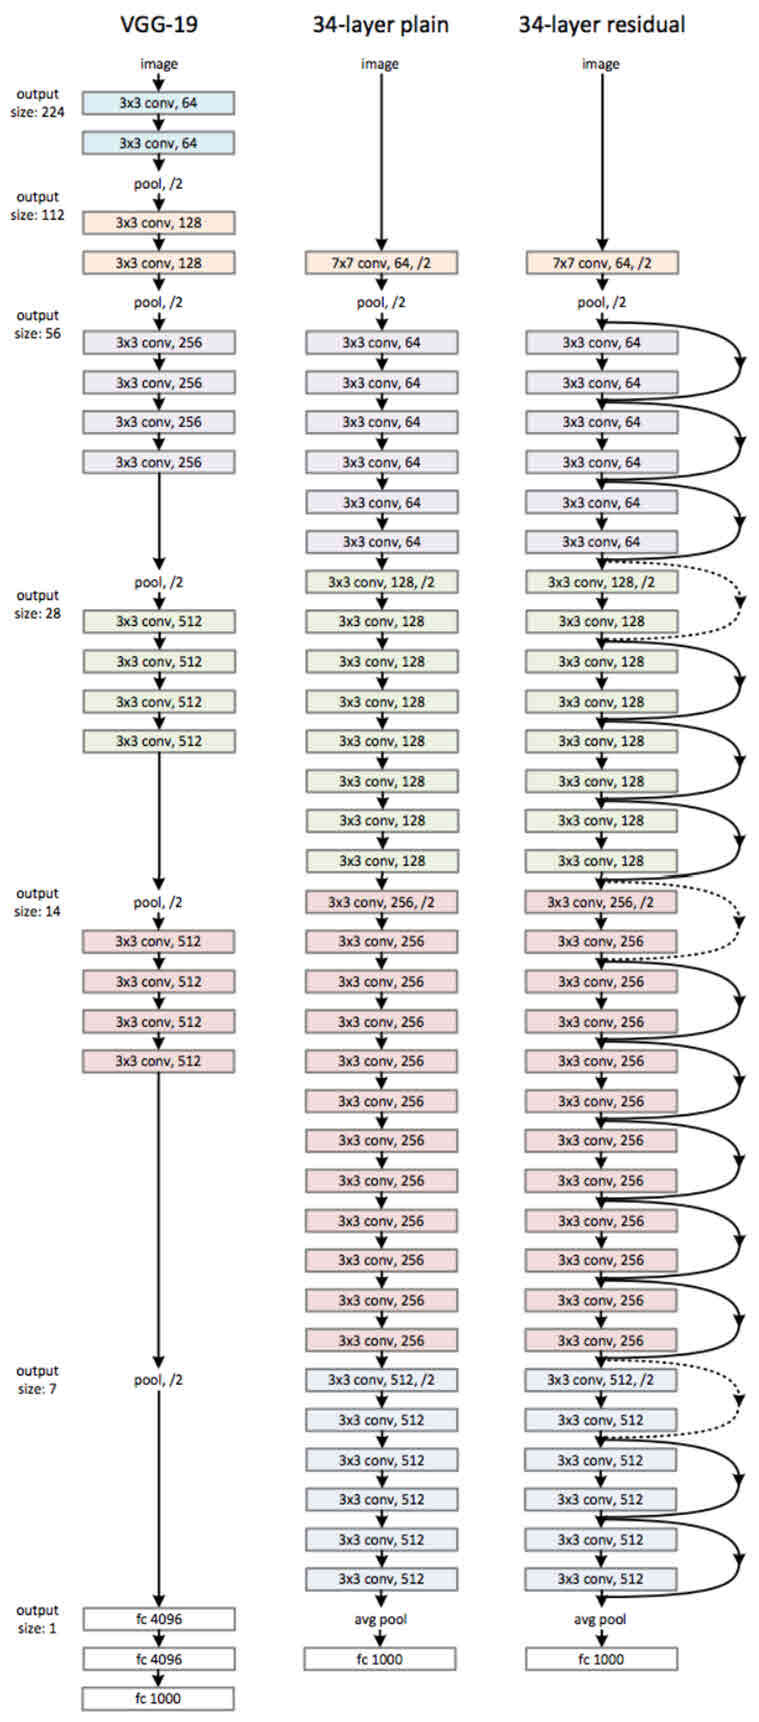

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import models

def resnet34(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, 8, 3)
    x = residual_block(x, 8, 3)
    x = residual_block(x, 8, 3)

    x = residual_block(x, 16, 3, strides=2)
    x = residual_block(x, 16, 3)
    x = residual_block(x, 16, 3)
    x = residual_block(x, 16, 3)

    x = residual_block(x, 32, 3, strides=2)
    x = residual_block(x, 32, 3)
    x = residual_block(x, 32, 3)
    x = residual_block(x, 32, 3)
    x = residual_block(x, 32, 3)
    x = residual_block(x, 32, 3)

    x = residual_block(x, 64, 3, strides=2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 64, 3)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, x)
    return model


def residual_block(x, filters, kernel_size, strides=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


In [8]:
input_shape = (150, 150, 1)

model = resnet34(input_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 150, 150, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 150, 150, 1)  0           sequential[1][0]                 
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 75, 75, 64)   3200        rescaling_1[0][0]                
____________________________________________________________________________________________

In [9]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="chest_with_resnet34.keras",
        save_best_only=True,
        monitor='val_loss'
    ),
    keras.callbacks.TensorBoard(
        log_dir="resnet34/logs"
    )
]

In [10]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history = model.fit(train_dataset, validation_data=val_dataset,
                    epochs=50, callbacks=callbacks)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/50
163/163 [==============================] - 27s 114ms/step - loss: 0.2905 - accuracy: 0.8808 - val_loss: 3.1516 - val_accuracy: 0.5000
Epoch 2/50
163/163 [==============================] - 19s 110ms/step - loss: 0.1906 - accuracy: 0.9256 - val_loss: 1.8172 - val_accuracy: 0.5000
Epoch 3/50
163/163 [==============================] - 18s 107ms/step - loss: 0.1592 - accuracy: 0.9383 - val_loss: 0.6244 - val_accuracy: 0.6875
Epoch 4/50
163/163 [==============================] - 18s 105ms/step - loss: 0.1342 - accuracy: 0.9486 - val_loss: 4.0361 - val_accuracy: 0.5000
Epoch 5/50
163/163 [==============================] - 18s 103ms/step - loss: 0.1349 - accuracy: 0.9484 - val_loss: 0.9114 - val_accuracy: 0.5625
Epoch 6/50
163/163 [==============================] - 18s 104ms/step - loss: 0.1123 - accuracy: 0.9592 - val_loss: 0.8100 - val_accuracy: 0.6250


In [11]:
model.evaluate(test_dataset)

20/20 [==============================] - 1s 43ms/step - loss: 0.6479 - accuracy: 0.7660


[0.6479489207267761, 0.7660256624221802]

https://tensorboard.dev/experiment/PeaKa7qlSpmwWbNnIbw0cQ/#scalars
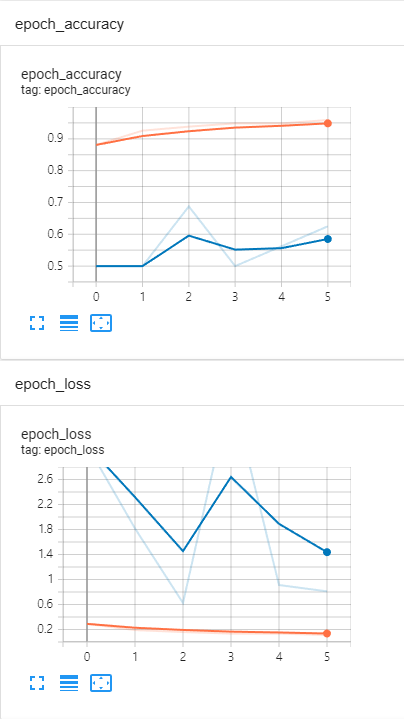

vgg16보다 ResNet32를 사용했을 때 더 결과가 잘 나오는 것을 알 수 있습니다.

CLI 명령어

pip install protobuf==3.20.0
export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python
tensorboard dev upload --logdir logs --name "My TensorBoard"